
# Linear Regression from Scratch

This notebook implements **Linear Regression** using **Batch Gradient Descent** and **Normal Equation** methods, 
as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 2)** by Andrew Ng.

It includes:
- Feature normalization using Z-score
- Cost function visualization
- Optimization using gradient descent
- Closed-form solution using the normal equation
- 3D plots and performance comparison

> 📘 This is part of a broader `ml-from-scratch` project implementing ML algorithms using only NumPy and pandas for educational purposes.


In [34]:
import pickle
import numpy as np
from typing import Union,List
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [43]:
class LinearRegression:
    def __init__(self):
        self.x_mean : ndarray = None
        self.x_std : ndarray = None
        self.y_mean : ndarray = None
        self.y_std : ndarray = None
        self.Theta : ndarray = None
        self.theta : ndarray = None
        self.x_norm : ndarray = None
        self.y_norm : ndarray = None
    def normalize(self, x_train: ndarray, y_train: ndarray, add_bias=True):
        x_mean, x_std = x_train.mean(axis=0), x_train.std(axis=0)
        x_norm = (x_train - x_mean) / x_std
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        y_norm = (y_train - y_mean) / y_std
        if add_bias:
            x_0 = np.ones((x_norm.shape[0], 1))
            x_norm = np.hstack((x_0, x_norm), dtype=x_norm.dtype)
        
        m, n = x_norm.shape
        self.x_mean = x_mean
        self.x_std = x_std
        self.x_norm = x_norm
        self.y_mean = y_mean
        self.y_std = y_std
        self.y_norm = y_norm

        return x_norm, y_norm, m, n, x_mean, x_std, y_mean, y_std
    
    def h(self, x: ndarray, theta: ndarray) -> ndarray:
        return np.dot(x, theta)
    
    def J(self, x: ndarray, y: ndarray ,theta: ndarray) -> float:
        m = x.shape[0]
        error = self.h(x,theta) - y
        return (1 / (2 * m)) * np.sum(np.square(error))
    
    def fit(self, x_train: ndarray, y_train: ndarray, add_bias: bool = True) -> ndarray:
        self.normalize(x_train, y_train, add_bias)
        XtX_inv = np.linalg.pinv(self.x_norm.T @ self.x_norm)
        Xty = self.x_norm.T @ self.y_norm
        theta = XtX_inv @ Xty
        loss = self.J(self.x_norm, self.y_norm, theta)
        print(f"Loss = {loss}")

        self.Theta=theta

        return theta
    
    def train(self ,x_train : ndarray, y_train :ndarray, alpha : float, theta : ndarray = None, epoch : int = 100, add_bias: bool = True) -> ndarray:
        self.normalize(x_train, y_train, add_bias)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        epochs, losses = list(range(1, epoch + 1)), list()
        m = self.x_norm.shape[0]
        for _ in range(epoch):
            error = self.h(self.x_norm, theta) - self.y_norm
            grad = (1 / m) * self.x_norm.T @ error
            theta -= alpha * grad
            losses.append(self.J(self.x_norm, self.y_norm, theta))

        self.theta = theta

        print(f"Loss = {self.J(self.x_norm, self.y_norm, theta)}")
        plt.plot(epochs, losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()
        return theta
    
    def save(self, filepath) -> None:
        data = {
            "x_mean" : self.x_mean,
            "x_std" : self.x_std,
            "y_mean" : self.y_mean,
            "y_std" : self.y_std,
            "theta" : self.theta,
            "Theta" : self.Theta
        }

        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        
    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            self.x_mean = data.get("x_mean")
            self.x_std = data.get("x_std")
            self.y_mean = data.get("y_mean")
            self.y_std = data.get("y_std")
            self.theta = data.get("theta")
            self.Theta = data.get("Theta")

            if self.x_mean is None or self.x_std is None:
                raise ValueError("Missing normalization parameters: x_mean or x_std.")
            if self.y_mean is None or self.y_std is None:
                raise ValueError("Missing normalization parameters: y_mean or y_std.")
            if self.theta is None and self.Theta is None:
                raise ValueError("Neither theta nor Theta available for predictions.")

        def h(self, x: ndarray, theta: ndarray) -> ndarray:
            return np.dot(x, theta)

        def predict(
            self,
            X_input: Union[List[float], List[List[float]]],
            use_theta: bool = False,
            use_Theta: bool = False,
            add_bias: bool = False
        ) -> ndarray:
            X_input = np.array(X_input, dtype=float)
            if X_input.ndim == 1:
                X_input = X_input.reshape(1, -1)

            X_norm = (X_input - self.x_mean) / self.x_std

            if add_bias:
                if not np.allclose(X_norm[:, 0], 1.0):
                    X_norm = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

            theta_used = None
            if use_theta and self.theta is not None:
                theta_used = self.theta
                print("Using `theta`")
            elif use_Theta and self.Theta is not None:
                theta_used = self.Theta
                print("Using `Theta`")
            elif self.Theta is not None:
                theta_used = self.Theta
                print("Using `Theat`")
            elif self.theta is not None:
                theta_used = self.theta
                print("Using `theta`")
            else:
                raise ValueError("No valid theta or Theta found.")

            # Predict and denormalize
            y_pred_norm = self.h(X_norm, theta_used)
            y_pred = y_pred_norm * self.y_std + self.y_mean
            return y_pred       


In [44]:
data = pd.read_csv("./data/Data.txt", header=None,
                   names=["Size_sqft", "Bedrooms", "Price_USD"])
print(data.isnull().sum())
data.head()

Size_sqft    0
Bedrooms     0
Price_USD    0
dtype: int64


,Size_sqft,Bedrooms,Price_USD
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [39]:
x_train = data[["Size_sqft", "Bedrooms"]].values
y_train = data[["Price_USD"]].values

Loss = 0.13352749098554287
Loss = 0.1335420409574586


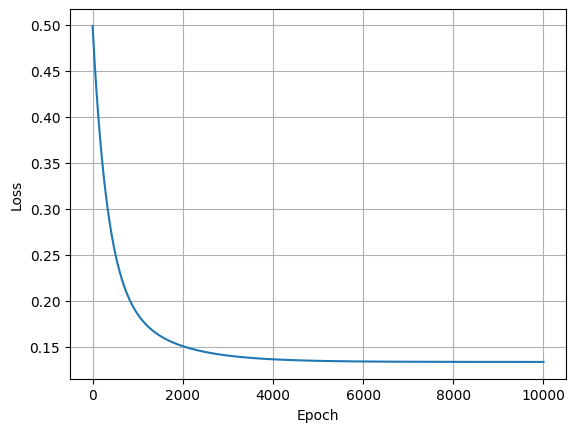

In [45]:
model = LinearRegression()

model.fit(x_train,y_train,add_bias=True)
model.train(x_train,y_train, 0.001, epoch= 10000, add_bias= True)

model.save("params.pkl")

In [47]:
inference = LinearRegression.Loader("params.pkl")
y_pred = inference.predict([1500, 3],use_Theta=True , add_bias=True)
print("Predicted:", y_pred[0])

Using `Theta`
Predicted: [272199.86323225]


Using `Theta`
Using `theta`


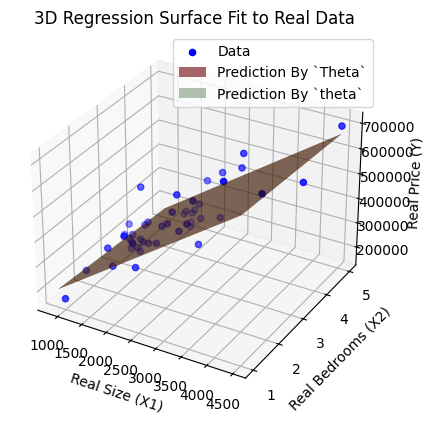

In [48]:
X_1 = data[["Size_sqft"]].values
X_2 = data[["Bedrooms"]].values
Y = data[["Price_USD"]].values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_1, X_2, Y, c='blue', label='Data')

x1_range = np.linspace(X_1.min(), X_1.max(), 50)
x2_range = np.linspace(X_2.min(), X_2.max(), 50)
x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)

x1_flat = x1_mesh.ravel()
x2_flat = x2_mesh.ravel()
X_surface = np.column_stack([ x1_flat, x2_flat])
Y_surface_Theta = inference.predict(X_surface,use_Theta=True, add_bias=True).reshape(x1_mesh.shape)
Y_surface_theta = inference.predict(X_surface,use_theta=True, add_bias=True).reshape(x1_mesh.shape)

ax.plot_surface(x1_mesh, x2_mesh, Y_surface_Theta, color='red',
                alpha=0.6, label='Prediction By `Theta`')
ax.plot_surface(x1_mesh, x2_mesh, Y_surface_Theta, color='green',
                alpha=0.3, label='Prediction By `theta`')

ax.set_xlabel('Real Size (X1)')
ax.set_ylabel('Real Bedrooms (X2)')
ax.set_zlabel('Real Price (Y)')
plt.title('3D Regression Surface Fit to Real Data')
plt.legend()
plt.show()

Using `theta`
Using `Theta`


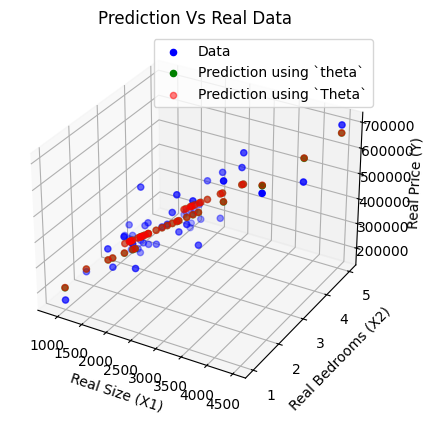

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_1, X_2, Y, c='blue', label='Data')

theta_pred = inference.predict(x_train,use_theta=True, add_bias=True)
Theta_pred = inference.predict(x_train,use_Theta=True, add_bias=True)
ax.scatter(X_1, X_2, theta_pred, label='Prediction using `theta`', c='green')
ax.scatter(X_1, X_2, Theta_pred, label='Prediction using `Theta`', c='red', alpha=0.5)
ax.set_xlabel('Real Size (X1)')
ax.set_ylabel('Real Bedrooms (X2)')
ax.set_zlabel('Real Price (Y)')
plt.title('Prediction Vs Real Data')
plt.legend()
plt.show()
